In [3]:
# %load plotting.py
import glob
import json
import logging
import matplotlib.patheffects as path_effects
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from os.path import basename
from matplotlib import pyplot as plt
from shutil import copyfile


# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


# INPUT_PATH = 'output.final/'
# OUTPUT_PATH = 'output.final/images/'
# REPORT_PATH = 'output.final/report/'
INPUT_PATH = 'output/'
OUTPUT_PATH = 'output/images/'
REPORT_PATH = 'output/report/'

if not os.path.exists(REPORT_PATH):
    os.makedirs(REPORT_PATH)

TO_PROCESS = {
    'PI': {
        'path': 'PI',
        'file_regex': re.compile('(.*)_grid\.csv')
    },
    'VI': {
        'path': 'VI',
        'file_regex': re.compile('(.*)_grid\.csv')
    },
    'Q': {
        'path': 'Q',
        'file_regex': re.compile('(.*)_grid\.csv')
    }
}

the_best = {}

WATERMARK = False
GATECH_USERNAME = 'DO NOT STEAL'
TERM = 'Fall 2018'


def watermark(p):
    if not WATERMARK:
        return p

    ax = plt.gca()
    for i in range(1, 11):
        p.text(0.95, 0.95 - (i * (1.0/10)), '{} {}'.format(GATECH_USERNAME, TERM), transform=ax.transAxes,
               fontsize=32, color='gray',
               ha='right', va='bottom', alpha=0.2)
    return p


def plot_episode_stats(title_base, stats, smoothing_window=50):
    # Trim the DF down based on the episode lengths
    stats = stats[stats['length'] > 0]

    # Plot the episode length over time, both as a line and histogram
    fig1 = plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.grid()
    plt.tight_layout()
    plt.plot(stats['length'], color='red')
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    plt.subplot(122)
    plt.hist(stats['length'], zorder=3)
    plt.grid(zorder=0)
    plt.xlabel("Episode Length")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.title(title_base.format("Episode Length (Histogram)"))
    fig1 = watermark(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10, 5))
    rewards_smoothed = pd.Series(stats['reward']).rolling(
        smoothing_window, min_periods=smoothing_window
    ).mean()
    plt.subplot(121)
    plt.grid()
    plt.tight_layout()
    plt.plot(rewards_smoothed, color='green')
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time ({})".format(smoothing_window))
    plt.subplot(122)
    plt.tight_layout()
    plt.hist(stats['reward'], zorder=3)
    plt.grid(zorder=0)
    plt.xlabel("Episode Reward")
    plt.ylabel("Count")
    plt.title(title_base.format("Episode Reward (Histogram)"))
    fig2 = watermark(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.grid()
    plt.tight_layout()
    time_steps = np.cumsum(stats['time'])
    plt.plot(time_steps, np.arange(len(stats['time'])), color='darkblue')
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    plt.subplot(122)
    plt.tight_layout()
    plt.hist(time_steps, zorder=3)
    plt.grid(zorder=0)
    plt.xlabel("Time Step")
    plt.ylabel("Count")
    plt.title(title_base.format("Episode Time (Histogram)"))
    fig3 = watermark(fig3)

    return fig1, fig2, fig3


def plot_policy_map(title, policy, map_desc, color_map, direction_map):
    fig = plt.figure()
    ax = fig.add_subplot(111, xlim=(0, policy.shape[1]), ylim=(0, policy.shape[0]))
    font_size = 'x-large'
    if policy.shape[1] > 16:
        font_size = 'small'
    plt.title(title)
    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):
            y = policy.shape[0] - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1)
            p.set_facecolor(color_map[map_desc[i, j]])
            ax.add_patch(p)

            text = ax.text(x+0.5, y+0.5, direction_map[policy[i, j]], weight='bold', size=font_size,
                           horizontalalignment='center', verticalalignment='center', color='w')
            text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                                   path_effects.Normal()])

    plt.axis('off')
    plt.xlim((0, policy.shape[1]))
    plt.ylim((0, policy.shape[0]))
    plt.tight_layout()

    return watermark(plt)


def plot_value_map(title, v, map_desc, color_map):
    fig = plt.figure()
    ax = fig.add_subplot(111, xlim=(0, v.shape[1]), ylim=(0, v.shape[0]))
    font_size = 'x-large'
    if v.shape[1] > 16:
        font_size = 'small'

    v_min = np.min(v)
    v_max = np.max(v)
    bins = np.linspace(v_min, v_max, 100)
    v_red = np.digitize(v, bins)/100.0
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            value = np.round(v[i, j], 2)
            if len(str(value)) > 4:
                font_size = 'small'

    plt.title(title)
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            y = v.shape[0] - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1)
            p.set_facecolor(color_map[map_desc[i, j]])
            ax.add_patch(p)

            value = np.round(v[i, j], 2)

            red = v_red[i, j]
            text2 = ax.text(x+0.5, y+0.5, value, size=font_size,
                            horizontalalignment='center', verticalalignment='center', color=(1.0, 1.0-red, 1.0-red))
            text2.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                   path_effects.Normal()])

    plt.axis('off')
    plt.xlim((0, v.shape[1]))
    plt.ylim((0, v.shape[0]))
    plt.tight_layout()

    return watermark(plt)


def plot_time_vs_steps(title, df, xlabel="Steps", ylabel="Time (s)"):
    plt.close()
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.tight_layout()

    plt.plot(df.index.values, df['time'], '-', linewidth=1)
    plt.legend(loc="best")

    return watermark(plt)


def plot_reward_and_delta_vs_steps(title, df, xlabel="Steps", ylabel="Reward"):
    plt.close()
    plt.figure()

    f, (ax) = plt.subplots(1, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    lns1 = ax.plot(df.index.values, df['reward'], linewidth=1, label=ylabel, color='green')

    ex_ax = ax.twinx()
    lns2 = ex_ax.plot(df.index.values, df['delta'], linewidth=2, label='Delta', color='darkorange', marker='o', markersize=2)
    ex_ax.set_ylabel('Delta')
    ex_ax.tick_params('y')

    ax.grid()
    ax.axis('tight')

    f.tight_layout()

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)

    return watermark(plt)


# Adapted from http://code.activestate.com/recipes/578293-unicode-command-line-histograms/
def cli_hist(data, bins=10):
    bars = u' ▁▂▃▄▅▆▇█'
    n, bin_edges = np.histogram(data, bins=bins)
    n2 = map(int, np.floor(n*(len(bars)-1)/(max(n))))
    res = u' '.join(bars[i] for i in n2)

    return res


# Adapted from https://gist.github.com/joezuntz/2f3bdc2ab0ea59229907
def ascii_hist(data, bins=10):
    N, X = np.histogram(data, bins=bins)
    total = 1.0 * len(data)
    width = 50
    nmax = N.max()
    lines = []

    for (xi, n) in zip(X, N):
        bar = '#' * int(n * 1.0 * width / nmax)
        xi = '{0: <8.4g}'.format(xi).ljust(10)
        lines.append('{0}| {1}'.format(xi, bar))

    return lines


def fetch_mdp_name(file, regexp):
    search_result = regexp.search(basename(file))
    if search_result is None:
        return False, False

    mdp_name = search_result.groups()[0]

    return mdp_name, ' '.join(map(lambda x: x.capitalize(), mdp_name.split('_')))


def process_params(problem_name, params):
    param_str = '{}'.format(params['discount_factor'])
    if problem_name == 'Q':
        param_str = '{}_{}_{}_{}_{}'.format(params['alpha'], params['q_init'], params['epsilon'],
                                            params['epsilon_decay'], params['discount_factor'])

    return param_str


def find_optimal_params(problem_name, base_dir, file_regex):
    grid_files = glob.glob('{}/*_grid*.csv'.format(base_dir))
    logger.info("Grid files {}".format(grid_files))
    best_params = {}
    for f in grid_files:
        mdp, readable_mdp = fetch_mdp_name(f, file_regex)
        logger.info("MDP: {}, Readable MDP: {}".format(mdp, readable_mdp))
        df = pd.read_csv(f)
        best = df.copy()
        # Attempt to find the best params. First look at the reward mean, then median, then max. If at any point we
        # have more than one result as "best", try the next criterion
        for criterion in ['reward_mean', 'reward_median', 'reward_max']:
            best_value = np.max(best[criterion])
            best = best[best[criterion] == best_value]
            if best.shape[0] == 1:
                break

        # If we have more than one best, take the highest index.
        if best.shape[0] > 1:
            best = best.iloc[-1:]

        params = best.iloc[-1]['params']
        params = json.loads(params)
        best_index = best.iloc[-1].name

        best_params[mdp] = {
            'name': mdp,
            'readable_name': readable_mdp,
            'index': best_index,
            'params': params,
            'param_str': process_params(problem_name, params)
        }

    return best_params


def find_policy_images(base_dir, params):
    policy_images = {}
    for mdp in params:
        mdp_params = params[mdp]
        image_files = glob.glob('{}/{}_{}*.png'.format(base_dir, mdp_params['name'], mdp_params['param_str']))

        if len(image_files) == 2:
            policy_file = None
            value_file = None
            for image_file in image_files:
                if 'Value' in image_file:
                    value_file = image_file
                else:
                    policy_file = image_file

            logger.info("Value file {}, Policy File: {}".format(value_file, policy_file))
            policy_images[mdp] = {
                'value': value_file,
                'policy': policy_file
            }
        else:
            logger.error("Unable to find image file for {} with params {}".format(mdp, mdp_params))

    return policy_images


def find_data_files(base_dir, params):
    data_files = {}
    for mdp in params:
        mdp_params = params[mdp]
        files = glob.glob('{}/{}_{}.csv'.format(base_dir, mdp_params['name'], mdp_params['param_str']))
        optimal_files = glob.glob('{}/{}_{}_optimal.csv'.format(base_dir, mdp_params['name'], mdp_params['param_str']))
        episode_files = glob.glob('{}/{}_{}_episode.csv'.format(base_dir, mdp_params['name'], mdp_params['param_str']))
        logger.info("files {}".format(files))
        logger.info("optimal_files {}".format(optimal_files))
        logger.info("episode_files {}".format(episode_files))
        data_files[mdp] = {
            'file': files[0],
            'optimal_file': optimal_files[0]
        }
        if len(episode_files) > 0:
            data_files[mdp]['episode_file'] = episode_files[0]

    return data_files


def copy_best_images(best_images, base_dir):
    for problem_name in best_images:
        for mdp in best_images[problem_name]:
            mdp_files = best_images[problem_name][mdp]

            dest_dir = base_dir + '/' + problem_name
            policy_image = mdp_files['policy']
            value_image = mdp_files['value']

            if not os.path.exists(dest_dir):
                os.makedirs(dest_dir)

            policy_dest = dest_dir + '/' + basename(policy_image)
            value_dest = dest_dir + '/' + basename(value_image)
            logger.info("Copying {} to {}".format(policy_image, policy_dest))
            logger.info("Copying {} to {}".format(value_image, value_dest))

            copyfile(policy_image, policy_dest)
            copyfile(value_image, value_dest)


def copy_data_files(data_files, base_dir):
    for problem_name in data_files:
        for mdp in data_files[problem_name]:
            mdp_files = data_files[problem_name][mdp]

            dest_dir = base_dir + '/' + problem_name

            if not os.path.exists(dest_dir):
                os.makedirs(dest_dir)

            for file_type in mdp_files:
                file_name = mdp_files[file_type]
                file_dest = dest_dir + '/' + basename(file_name)

                logger.info("Copying {} file from {} to {}".format(file_type, file_name, file_dest))

                copyfile(file_name, file_dest)


def plot_data(data_files, envs, base_dir):
    for problem_name in data_files:
        for mdp in data_files[problem_name]:
            env = lookup_env_from_mdp(envs, mdp)
            if env is None:
                logger.error("Unable to find env for MDP {}".format(mdp))
                return

            mdp_files = data_files[problem_name][mdp]

            step_term = 'Steps'
            if problem_name == 'Q':
                step_term = 'Episodes'

            df = pd.read_csv(mdp_files['file'])

            title = '{}: {} - Time vs {}'.format(env['readable_name'],
                                                 problem_name_to_descriptive_name(problem_name), step_term)
            file_name = '{}/{}/{}_time.png'.format(base_dir, problem_name, mdp)
            p = plot_time_vs_steps(title, df, xlabel=step_term)
            p = watermark(p)
            p.savefig(file_name, format='png', dpi=150)
            p.close()

            reward_term = 'Reward'
            if problem_name in ['VI', 'PI']:
                reward_term = 'Value'

            title = '{}: {} - {} and Delta vs {}'.format(env['readable_name'],
                                                         problem_name_to_descriptive_name(problem_name),
                                                         reward_term, step_term)
            file_name = '{}/{}/{}_reward_delta.png'.format(base_dir, problem_name, mdp)
            p = plot_reward_and_delta_vs_steps(title, df, ylabel=reward_term, xlabel=step_term)
            p = watermark(p)
            p.savefig(file_name, format='png', dpi=150)
            p.close()

            if problem_name == 'Q' and 'episode_file' in mdp_files:
                title = '{}: {} - {}'.format(env['readable_name'], problem_name_to_descriptive_name(problem_name),
                                             '{}')
                episode_df = pd.read_csv(mdp_files['episode_file'])
                q_length, q_reward, q_time = plot_episode_stats(title, episode_df)
                file_base = '{}/{}/{}_{}.png'.format(base_dir, problem_name, mdp, '{}')

                logger.info("Plotting episode stats with file base {}".format(file_base))
                q_length.savefig(file_base.format('episode_length'), format='png', dpi=150)
                q_reward.savefig(file_base.format('episode_reward'), format='png', dpi=150)
                q_time.savefig(file_base.format('episode_time'), format='png', dpi=150)
                plt.close()


def lookup_env_from_mdp(envs, mdp):
    for env in envs:
        if env['name'] == mdp:
            return env

    return None


def problem_name_to_descriptive_name(problem_name):
    if problem_name == 'VI':
        return 'Value Iteration'
    if problem_name == 'PI':
        return 'Policy Iteration'
    if problem_name == 'Q':
        return "Q-Learner"
    return 'Unknown'


def plot_results(envs):
    best_params = {}
    best_images = {}
    data_files = {}
    for problem_name in TO_PROCESS:
        logger.info("Processing {}".format(problem_name))

        problem = TO_PROCESS[problem_name]
        problem_path = '{}/{}'.format(INPUT_PATH, problem['path'])
        problem_image_path = '{}/images/{}'.format(INPUT_PATH, problem['path'])

        best_params[problem_name] = find_optimal_params(problem_name, problem_path, problem['file_regex'])
        best_images[problem_name] = find_policy_images(problem_image_path, best_params[problem_name])
        data_files[problem_name] = find_data_files(problem_path, best_params[problem_name])

    copy_best_images(best_images, REPORT_PATH)
    copy_data_files(data_files, REPORT_PATH)
    plot_data(data_files, envs, REPORT_PATH)
    params_df = pd.DataFrame(best_params)
    params_df.to_csv('{}/params.csv'.format(REPORT_PATH))
    
    return data_files[problem_name] 


In [4]:
INPUT_PATH = 'output/'
problem['file_regex'] = re.compile('(.*)_grid\.csv')
#problem_path = '{}/{}'.format(INPUT_PATH, problem['path'])
problem_path = '{}/{}'.format(INPUT_PATH, 'Q')
best_params[problem_name] = find_optimal_params(problem_name, problem_path, problem['file_regex'])
data_files['Q'] = find_data_files(problem_path, best_params[problem_name])

find_data_files(base_dir, params)

NameError: name 'problem' is not defined

In [5]:
INPUT_PATH = 'output'
best_params = {}
best_images = {}
data_files = {}
# for problem_name in TO_PROCESS:
#     logger.info("Processing {}".format(problem_name))
problem_name = 'Q'
problem = TO_PROCESS[problem_name]
#problem = TO_PROCESS['Q']

problem_path = '../{}/{}'.format(INPUT_PATH, problem['path'])
problem_image_path = '../{}/images/{}'.format(INPUT_PATH, problem['path'])

best_params[problem_name] = find_optimal_params(problem_name, problem_path, problem['file_regex'])
best_images[problem_name] = find_policy_images(problem_image_path, best_params[problem_name])
data_files[problem_name] = find_data_files(problem_path, best_params[problem_name])


2019-04-12 10:56:18,214 - __main__ - INFO - Grid files ['../output/Q/windy_frozen_lake_grid.csv', '../output/Q/frozen_lake_grid.csv']
2019-04-12 10:56:18,217 - __main__ - INFO - MDP: windy_frozen_lake, Readable MDP: Windy Frozen Lake
2019-04-12 10:56:18,248 - __main__ - INFO - MDP: frozen_lake, Readable MDP: Frozen Lake
2019-04-12 10:56:18,274 - __main__ - INFO - Value file ../output/images/Q/windy_frozen_lake_0.1_0_0.1_0.0001_0.7_Value_Last.png, Policy File: ../output/images/Q/windy_frozen_lake_0.1_0_0.1_0.0001_0.7_Policy_Last.png
2019-04-12 10:56:18,280 - __main__ - INFO - Value file ../output/images/Q/frozen_lake_0.1_random_0.1_0.0001_0.6_Value_Last.png, Policy File: ../output/images/Q/frozen_lake_0.1_random_0.1_0.0001_0.6_Policy_Last.png
2019-04-12 10:56:18,282 - __main__ - INFO - files ['../output/Q/windy_frozen_lake_0.1_0_0.1_0.0001_0.7.csv']
2019-04-12 10:56:18,284 - __main__ - INFO - optimal_files ['../output/Q/windy_frozen_lake_0.1_0_0.1_0.0001_0.7_optimal.csv']
2019-04-12 10:

In [6]:
data_files

{'Q': {'frozen_lake': {'episode_file': '../output/Q/frozen_lake_0.1_random_0.1_0.0001_0.6_episode.csv',
   'file': '../output/Q/frozen_lake_0.1_random_0.1_0.0001_0.6.csv',
   'optimal_file': '../output/Q/frozen_lake_0.1_random_0.1_0.0001_0.6_optimal.csv'},
  'windy_frozen_lake': {'episode_file': '../output/Q/windy_frozen_lake_0.1_0_0.1_0.0001_0.7_episode.csv',
   'file': '../output/Q/windy_frozen_lake_0.1_0_0.1_0.0001_0.7.csv',
   'optimal_file': '../output/Q/windy_frozen_lake_0.1_0_0.1_0.0001_0.7_optimal.csv'}}}

In [7]:
episode_df = pd.read_csv('../output/Q/frozen_lake_0.1_random_0.1_0.0001_0.6_episode.csv')
#'../output/Q/windy_frozen_lake_0.1_0_0.1_0.0001_0.7.csv'

In [8]:
episode_df[990:1001]

,episode,length,time,reward,delta
990,990,500.0,0.036393,-16.35,-0.029729
991,991,500.0,0.037283,-18.25,0.000909
992,992,500.0,0.035553,-17.55,0.001068
993,993,250.0,0.018831,-10.30,0.398630
994,994,350.0,0.027814,-16.85,-0.897162
995,995,500.0,0.035586,-20.70,0.021330
996,996,500.0,0.035490,-18.35,-0.047999
997,997,150.0,0.011386,-6.35,0.783295
998,998,100.0,0.007423,-2.95,0.721790
999,999,457.0,0.033812,-17.30,-0.887724


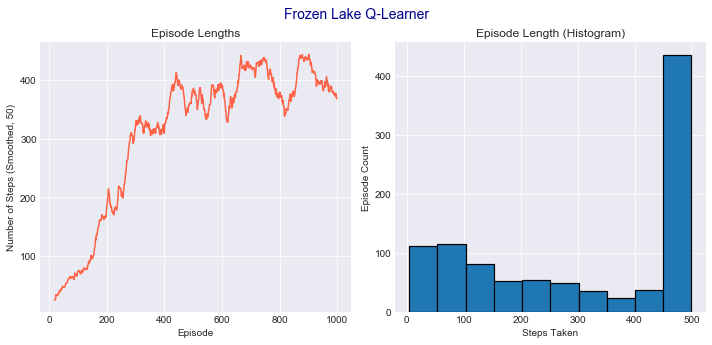

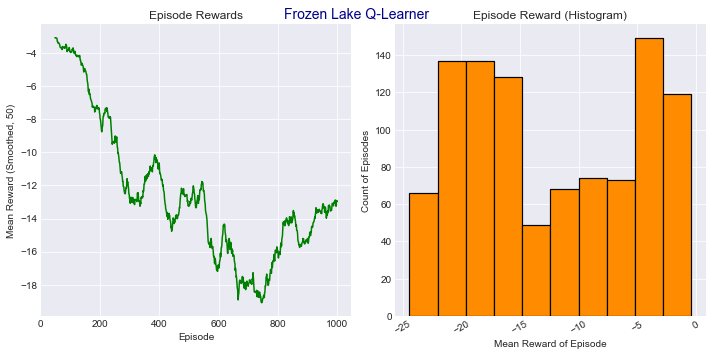

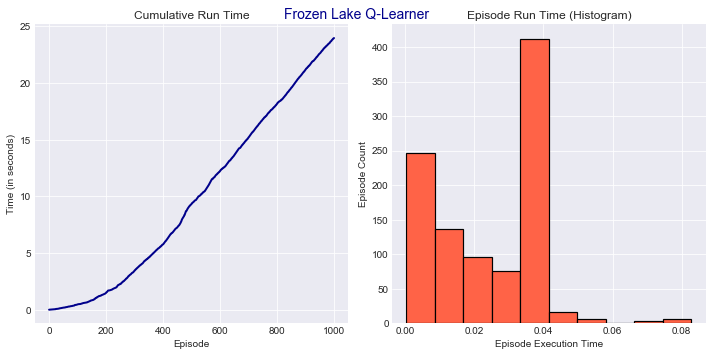

In [18]:
# PLOT EPISODE STATS ---------------------------
#def plot_episode_stats(title_base, stats, smoothing_window=50):
title_base = "Frozen Lake Q-Learner"
stats = episode_df
smoothing_window=50    
    
# Trim the DF down based on the episode lengths
stats = stats[stats['length'] > 0]

# Plot the episode length over time, both as a line and histogram
fig1 = plt.figure(figsize=(10, 5))
length_smoothed = pd.Series(stats['length']).rolling(50, min_periods=20).mean()
plt.subplot(121)
#plt.grid()
plt.tight_layout()
#plt.plot(stats['length'], color='red')
plt.plot(length_smoothed, color='tomato')
length_smoothed
plt.xlabel("Episode")
plt.ylabel("Number of Steps (Smoothed, 50)")
plt.title("Episode Lengths")


plt.subplot(122)
plt.hist(stats['length'], zorder=3, edgecolor='black', linewidth=1.2)
#plt.hist(stats['steps'], zorder=3, edgecolor='black', linewidth=1.2)

#plt.tight_layout()
#plt.grid(zorder=0)
plt.xlabel("Steps Taken")
plt.ylabel("Episode Count")
plt.tight_layout()
plt.title("Episode Length (Histogram)")
fig1 = watermark(fig1)
fig1.suptitle(title_base, color='darkblue', fontsize=14, weight=2, va='top')
fig1.tight_layout(rect=[0, 0.03, 1, 0.95])

# Plot the episode reward over time ------------------------------------
fig2 = plt.figure(figsize=(10, 5))
rewards_smoothed = pd.Series(stats['reward']).rolling(
    smoothing_window, min_periods=smoothing_window
).mean()
plt.subplot(121)
#plt.grid()
plt.tight_layout()
plt.plot(rewards_smoothed, color='green')
plt.xlabel("Episode")
plt.ylabel("Mean Reward (Smoothed, {})".format(smoothing_window))
plt.title("Episode Rewards")

plt.subplot(122)
plt.tight_layout()
plt.hist(stats['reward'], color='darkorange',zorder=3, edgecolor='black', linewidth=1.2)
plt.tight_layout()
plt.grid(zorder=0)
plt.tight_layout()
plt.xlabel("Mean Reward of Episode")
plt.ylabel("Count of Episodes")
plt.xticks(rotation=30)
plt.title("Episode Reward (Histogram)")
fig2.tight_layout()
fig2.suptitle(title_base, color='darkblue', fontsize=14, weight=2, va='top')

# Plot time steps and episode number --------------------------------
fig3 = plt.figure(figsize=(10, 5))
plt.subplot(121)
#plt.grid()
plt.tight_layout()
time_steps = np.cumsum(stats['time'])
plt.plot(np.arange(len(stats['time'])),time_steps, color='darkblue', linewidth=2)
plt.tight_layout()
plt.ylabel("Time (in seconds)")
plt.xlabel("Episode")
plt.title("Cumulative Run Time")

plt.subplot(122)
plt.hist(stats['time'], zorder=3, edgecolor='black', linewidth=1.2, color='tomato')
#plt.tight_layout()
#plt.grid(zorder=0)
plt.tight_layout()
plt.xlabel("Episode Execution Time")
plt.ylabel("Episode Count")
plt.title("Episode Run Time (Histogram)")
fig3.tight_layout()
fig3.suptitle(title_base, color='darkblue', fontsize=14, weight=2, va='top')

plt.show()

#return fig1, fig2, fig3


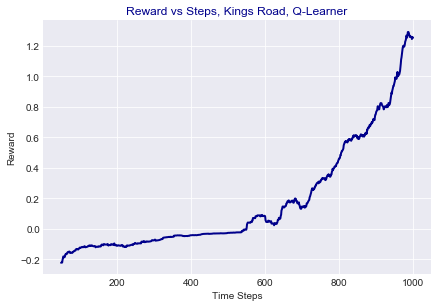

In [266]:
# REWARD VS STEPS =============
df = pd.read_csv('../output/Q/seven_kingdoms_0.1_0_0.1_0.0001_0.7.csv')
smoothing_window = 50
#'../output/Q/windy_frozen_lake_0.1_0_0.1_0.0001_0.7.csv'
plt.style.use('seaborn-darkgrid')
#plt.grid()
#plt.tight_layout()
#time_steps = np.cumsum(stats['time'])
#time_steps = np.cumsum(stats['time'])
smoothed = pd.Series(df['reward']).rolling(smoothing_window, min_periods=smoothing_window).mean()
#plt.plot(np.arange(len(stats['time'])),time_steps, color='darkblue', linewidth=2)
plt.plot(np.arange(len(df['reward'])),smoothed, color='darkblue', linewidth=2)

plt.tight_layout()
plt.ylabel("Reward")
plt.xlabel("Time Steps")
plt.title("Reward vs Steps, Kings Road, Q-Learner", color='darkblue')
plt.show()


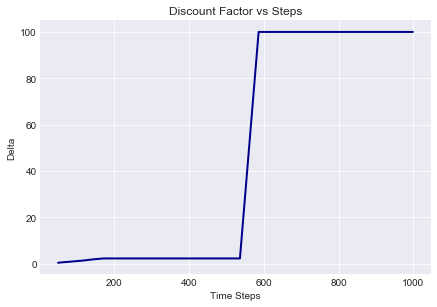

In [16]:
# DELTA VS STEPS ===============
df_q = pd.read_csv('../output/Q/seven_kingdoms_0.1_0_0.1_0.0001_0.7.csv')
df_vi = pd.read_csv('../output/VI/seven_kingdoms_lake_0.1_0_0.1_0.0001_0.7.csv')
df_pi = pd.read_csv('../output/PI/seven_kingdoms_lake_0.1_0_0.1_0.0001_0.7.csv')
smoothing_window = 50
#'../output/Q/windy_frozen_lake_0.1_0_0.1_0.0001_0.7.csv'
plt.style.use('seaborn-darkgrid')
#plt.grid()
#plt.tight_layout()
#time_steps = np.cumsum(stats['time'])
#time_steps = np.cumsum(stats['time'])
smoothed = pd.Series(df['delta']).rolling(smoothing_window, min_periods=smoothing_window).mean()
#plt.plot(np.arange(len(stats['time'])),time_steps, color='darkblue', linewidth=2)
plt.plot(np.arange(len(df['delta'])),smoothed, color='darkblue', linewidth=2)

plt.tight_layout()
plt.ylabel("Delta")
plt.xlabel("Time Steps")
plt.title("Discount Factor vs Steps")
plt.show()


In [272]:
# Value Iteration
#vi_ep = pd.read_csv('../output/VI/seven_kingdoms_0.8_episode')
vi_opt = pd.read_csv('../output/report/VI/seven_kingdoms_0.8_optimal.csv')
vi_df = pd.read_csv('../output/report/VI/seven_kingdoms_0.8.csv')

In [274]:
# Q Learning
q_ep = pd.read_csv('../output/Q/seven_kingdoms_0.1_0_0.1_0.0001_0.7_episode.csv')
q_opt = pd.read_csv('../output/Q/seven_kingdoms_0.1_0_0.1_0.0001_0.7_optimal.csv')
q_df = pd.read_csv('../output/Q/seven_kingdoms_0.1_0_0.1_0.0001_0.7.csv')

In [ ]:
# REWARD VS STEPS =============
df = pd.read_csv('../output/Q/seven_kingdoms_0.1_0_0.1_0.0001_0.7.csv')
smoothing_window = 50
#'../output/Q/windy_frozen_lake_0.1_0_0.1_0.0001_0.7.csv'
plt.style.use('seaborn-darkgrid')
#plt.grid()
#plt.tight_layout()
#time_steps = np.cumsum(stats['time'])
#time_steps = np.cumsum(stats['time'])
smoothed = pd.Series(df['reward']).rolling(smoothing_window, min_periods=smoothing_window).mean()
#plt.plot(np.arange(len(stats['time'])),time_steps, color='darkblue', linewidth=2)
plt.plot(np.arange(len(df['reward'])),smoothed, color='darkblue', linewidth=2)

plt.tight_layout()
plt.ylabel("Reward")
plt.xlabel("Time Steps")
plt.title("Reward vs Steps, Kings Road, Q-Learner", color='darkblue')
plt.show()


In [ ]:
def plot_reward_and_delta_vs_steps(title, df, xlabel="Steps", ylabel="Reward"):
    plt.close()
    plt.figure()

    f, (ax) = plt.subplots(1, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    smoothing_window = 50
    delta_smoothed = pd.Series(df['delta']).rolling(smoothing_window, min_periods=smoothing_window).mean()

    #lns1 = ax.plot(df.index.values, df['reward'], linewidth=1, label=ylabel, color='green')
    lns1 = ax.plot(df.index.values, delta_smoothed, linewidth=1, label=ylabel, color='green')
    

    ex_ax = ax.twinx()
    lns2 = ex_ax.plot(df.index.values, df['delta'], linewidth=2, label='Delta', color='darkorange', marker='o', markersize=2)
    ex_ax.set_ylabel('Delta')
    ex_ax.tick_params('y')

    ax.grid()
    ax.axis('tight')

    f.tight_layout()

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)

    return watermark(plt)

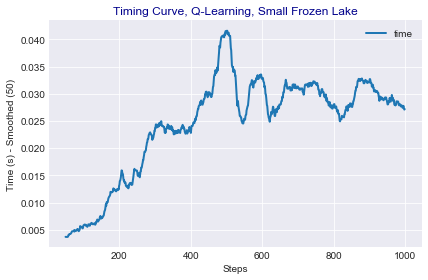

In [27]:
# RUN TIME BY NUMBER OF STEPS -------------------------
#def plot_time_vs_steps(title, df, xlabel="Steps", ylabel="Time (s)"):
df = pd.read_csv('../output/Q/frozen_lake_0.1_random_0.1_0.0001_0.6.csv')

# add smoothing
smoothing_window = 50
time_smoothed = pd.Series(df['time']).rolling(smoothing_window, min_periods=smoothing_window).mean()

x_label="Steps"
y_label="Time (s) - Smoothed (50)"
title = 'Timing Curve, Q-Learning, Small Frozen Lake'
plt.close()
plt.figure()
plt.title(title, color='darkblue')
plt.xlabel(x_label)
plt.ylabel(y_label)
#plt.legend(frameon=True)
#plt.grid()
plt.tight_layout()

plt.plot(df.index.values, time_smoothed, '-', linewidth=2)
plt.legend(loc="best")
#plt.savefig('../output/report/Q/frozen_lake_timing_curve.png')
plt.show()
#return watermark(plt)

In [41]:
#def find_optimal_params(problem_name, base_dir, file_regex):
problem_name= 'Q'
base_dir= problem_path
file_regex = re.compile('(.*)_grid\.csv')

grid_files = glob.glob('../output/Q/*_grid*.csv') #.format(base_dir))
logger.info("Grid files {}".format(grid_files))
best_params = {}
for f in grid_files:
    mdp, readable_mdp = fetch_mdp_name(f, file_regex)
    logger.info("MDP: {}, Readable MDP: {}".format(mdp, readable_mdp))
    df = pd.read_csv(f)
    best = df.copy()
    # Attempt to find the best params. First look at the reward mean, then median, then max. If at any point we
    # have more than one result as "best", try the next criterion
    for criterion in ['reward_mean', 'reward_median', 'reward_max']:
        best_value = np.max(best[criterion])
        best = best[best[criterion] == best_value]
        if best.shape[0] == 1:
            break

    # If we have more than one best, take the highest index.
    if best.shape[0] > 1:
        best = best.iloc[-1:]

    params = best.iloc[-1]['params']
    params = json.loads(params)
    best_index = best.iloc[-1].name

    best_params[mdp] = {
        'name': mdp,
        'readable_name': readable_mdp,
        'index': best_index,
        'params': params,
        'param_str': process_params(problem_name, params)
    }

#return best_params
best_params

{'frozen_lake': {'index': 19,
  'name': 'frozen_lake',
  'param_str': '0.1_random_0.3_0.0001_0.9',
  'params': {'alpha': 0.1,
   'discount_factor': 0.9,
   'epsilon': 0.3,
   'epsilon_decay': 0.0001,
   'q_init': 'random'},
  'readable_name': 'Frozen Lake'},
 'windy_frozen_lake': {'index': 19,
  'name': 'windy_frozen_lake',
  'param_str': '0.1_random_0.3_0.0001_0.9',
  'params': {'alpha': 0.1,
   'discount_factor': 0.9,
   'epsilon': 0.3,
   'epsilon_decay': 0.0001,
   'q_init': 'random'},
  'readable_name': 'Windy Frozen Lake'}}

In [33]:
grid_files = glob.glob('../output/Q/*_grid*.csv') #.format(base_dir))
grid_files

['../output/Q/windy_frozen_lake_grid.csv', '../output/Q/frozen_lake_grid.csv']

In [50]:
#def plot_data(data_files, envs, base_dir):
envs = [
        {
            # This is not really a rewarding frozen lake env, but the custom class has extra functionality
            'env': environments.get_rewarding_frozen_lake_environment(),
            'name': 'frozen_lake',
            'readable_name': 'Frozen Lake (8x8)',
        },
        # {
        #     'env': environments.get_large_rewarding_no_reward_frozen_lake_environment(),
        #     'name': 'large_frozen_lake',
        #     'readable_name': 'Frozen Lake (20x20)',
        # },
        # {
        #     'env': environments.get_windy_cliff_walking_environment(),
        #     'name': 'cliff_walking',
        #     'readable_name': 'Cliff Walking (4x12)',
        # },
        {
            'env': environments.get_windy_frozen_lake_environment(),
            'name': 'windy_frozen_lake',
            'readable_name': 'Windy Frozen Lake (16x16)',
        }
    ]
base_dir = 'output'
for problem_name in data_files:
    for mdp in data_files[problem_name]:
        env = lookup_env_from_mdp(envs, mdp)
        #if env is None:
            #logger.error("Unable to find env for MDP {}".format(mdp))
            #return

        mdp_files = data_files[problem_name][mdp]

        step_term = 'Steps'
        if problem_name == 'Q':
            step_term = 'Episodes'

        df = pd.read_csv(mdp_files['file'])

        title = '{}: {} - Time vs {}'.format(env['readable_name'],
                                             problem_name_to_descriptive_name(problem_name), step_term)
        file_name = '{}/{}/{}_time.png'.format(base_dir, problem_name, mdp)
        p = plot_time_vs_steps(title, df, xlabel=step_term)
        p = watermark(p)
        p.savefig(file_name, format='png', dpi=150)
        p.close()

        reward_term = 'Reward'
        if problem_name in ['VI', 'PI']:
            reward_term = 'Value'

        title = '{}: {} - {} and Delta vs {}'.format(env['readable_name'],
                                                     problem_name_to_descriptive_name(problem_name),
                                                     reward_term, step_term)
        file_name = '{}/{}/{}_reward_delta.png'.format(base_dir, problem_name, mdp)
        p = plot_reward_and_delta_vs_steps(title, df, ylabel=reward_term, xlabel=step_term)
        p = watermark(p)
        p.savefig(file_name, format='png', dpi=150)
        p.close()

        if problem_name == 'Q' and 'episode_file' in mdp_files:
            title = '{}: {} - {}'.format(env['readable_name'], problem_name_to_descriptive_name(problem_name),
                                         '{}')
            episode_df = pd.read_csv(mdp_files['episode_file'])
            q_length, q_reward, q_time = plot_episode_stats(title, episode_df)
            file_base = '{}/{}/{}_{}.png'.format(base_dir, problem_name, mdp, '{}')

            logger.info("Plotting episode stats with file base {}".format(file_base))
            q_length.savefig(file_base.format('episode_length'), format='png', dpi=150)
            q_reward.savefig(file_base.format('episode_reward'), format='png', dpi=150)
            q_time.savefig(file_base.format('episode_time'), format='png', dpi=150)
            plt.close()


NameError: name 'environments' is not defined

In [45]:
# RENAME THE QLEARNING FILES ===============================
import os

paths = (os.path.join(root, filename)
        for root, _, filenames in os.walk('../output/images/Q')
        for filename in filenames)

for path in paths:
    # the '#' in the example below will be replaced by the '-' in the filenames in the directory
    newname = path.replace('frozen_lake', 'kings_road')
    if newname != path:
        os.rename(path, newname)

In [120]:
# Set up to PLOT THE REWARDS FROM GRID FILES ========================================
prob = [
    {'name':'kings_road' , 'title':"Kings Road" },
    {'name':'seven_kingdoms', 'title': 'Seven Kingdoms'}
    ]

alg = [
    {'name': 'VI', 'title':'Value Iteration'},
    {'name': 'PI', 'title':'Policy Iteration'},
    {'name': 'Q', 'title':'Q-Learning'},
    ]

# attr = [
#     {'name': 'disc', 'title':'Discount Factor'},
#     {'name': 'reward_mean', 'title':'Mean Reward'},
#     ]




In [ ]:
# PLOT THE REWARDS FROM GRID FILES ========================================
# -------------------------------------------------------------------------

In [320]:
# get the data
a = 2
#for a in range(len(alg)):
alg_name = alg[a]['name']
alg_title = alg[a]['title'] 
print (alg_name , alg_title)
path = '../output/'+alg_name+'/'
output = '../output/report/images/'

p=1    
#for p in range(len(prob)):
prob_name = prob[p]['name']
prob_title = prob[p]['title']
print(prob_name, prob_title)
file = '{}_grid.csv'.format(prob_name)
data = pd.read_csv(path+file)
#data.head()

Q Q-Learning
seven_kingdoms Seven Kingdoms


In [324]:
# isolate the discount factor and other paramters for the algo's
import ast

data['disc'] = 0


for i in range(len(data)):
    if alg_name in ('PI', 'VI'):
        x = ast.literal_eval(data['params'].iloc[i])
        disc = x['discount_factor']#data['params'].iloc[i][-4:-1]
        data['disc'].iloc[i] = disc
        i+=1
    elif alg_name == 'Q':
        # create the new columns
        data['alpha'] = 0
        data['epsilon'] = 0
        data['epsilon_decay'] = 0
        data['q_init'] = 0
        # get the values for new columns
        # ast function turns string value into the dict it should be
        x = ast.literal_eval(data['params'].iloc[i])
        data['disc'].iloc[i] = x['discount_factor']
        data['alpha'].iloc[i] = x['alpha']
        data['epsilon'].iloc[i] = x['epsilon']
        data['epsilon_decay'].iloc[i] = x['epsilon_decay']
        data['q_init'].iloc[i] = x['q_init']
        i+=1
    


/Applications/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


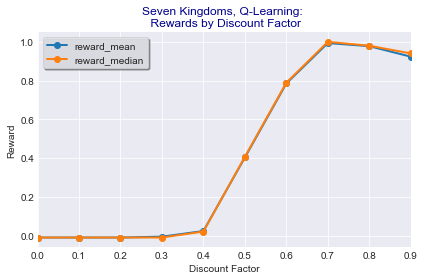

In [326]:
# PLOT REWARDS BY DISCOUNT FACTOR and save to file ==================

if alg_name in ('PI', 'VI'):
    #plot rewards by discount factor for VI and PI
    plt.close()
    data.plot('disc', ['reward_median','reward_mean'], linewidth=2, marker='o')
    plt.title(prob_title+', '+alg_title+': \n Learning Curve by Discount Factor', loc='center', 
              fontsize=12, fontweight=4, color='darkblue')
    plt.xlabel("Discount Factor")
    plt.ylabel('Reward')
    plt.legend(frameon=True, loc='best', shadow=True)
    plt.tight_layout()
    plt.savefig(output+alg_name+'/'+prob_name+'_LC_by_disc_factor.png')
    plt.show()

elif alg_name == 'Q':
    # plot rewards by discount factor for Q-learning ========

    # change disc to categorical variable
    data['disc'] = data['disc'].astype('category')
    # get mean and median rewards grouping by discount factor
    data_bydisc = data.groupby(['disc'])['reward_mean','reward_median'].mean()

    plt.close()
    data_bydisc.plot(linewidth=2, marker='o')
    plt.title(prob_title+', '+alg_title+': \n Rewards by Discount Factor', loc='center', 
              fontsize=12, fontweight=4, color='darkblue')
    plt.xlabel("Discount Factor")
    plt.ylabel('Reward')
    plt.legend(frameon=True, loc='best', shadow=True)
    plt.tight_layout()
    plt.savefig('../output/report/Q/'+prob_name+'_reward_by_disc_factor.png')
    plt.show()

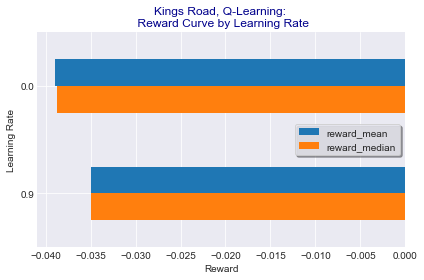

In [312]:
# plot rewards by alpha for Q-learning ========

# change disc to categorical variable
data['alpha'] = data['alpha'].astype('category')
# get mean and median rewards grouping by discount factor
data_bydisc = data.groupby(['alpha'])['reward_mean','reward_median'].mean()

plt.close()
data_bydisc.plot.barh() #(linewidth=2, marker='o')
plt.title(prob_title+', '+alg_title+': \n Reward Curve by Learning Rate', loc='center', 
          fontsize=12, fontweight=4, color='darkblue')
plt.xlabel("Reward")
plt.ylabel('Learning Rate')
#plt.ylim(ymax = 0, ymin =-0.05)
plt.gca().invert_yaxis()
plt.legend(frameon=True, loc='best', shadow=True)
plt.tight_layout()
plt.savefig('../output/report/Q/'+prob_name+'_LC_by_alpha.png')
plt.show()

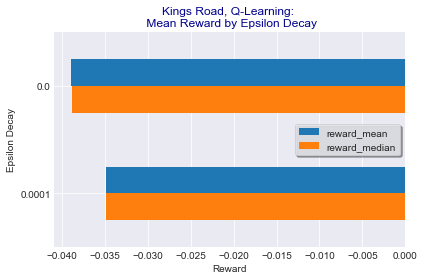

In [317]:
# plot rewards by epsilon for Q-learning ========

param = 'epsilon_decay'

# change disc to categorical variable
data[param] = data[param].astype('category')
# get mean and median rewards grouping by discount factor
data_bydisc = data.groupby([param])['reward_mean','reward_median'].mean()

plt.close()
data_bydisc.plot.barh() #(linewidth=2, marker='o')
plt.title(prob_title+', '+alg_title+': \n Mean Reward by Epsilon Decay', loc='center', 
          fontsize=12, fontweight=4, color='darkblue')
plt.xlabel("Reward")
plt.ylabel('Epsilon Decay')
#plt.ylim(ymax = 0, ymin =-0.05)
plt.gca().invert_yaxis()
plt.legend(frameon=True, loc='best', shadow=True)
plt.tight_layout()
plt.savefig('../output/report/Q/'+prob_name+'_rewards_by_epsilon_decay.png')
plt.show()

In [ ]:
# plot rewards by epsilon decay for Q-learning ========

param = 'epsilon'

# change disc to categorical variable
data[param] = data[param].astype('category')
# get mean and median rewards grouping by discount factor
data_bydisc = data.groupby([param])['reward_mean','reward_median'].mean()

plt.close()
data_bydisc.plot.barh() #(linewidth=2, marker='o')
plt.title(prob_title+', '+alg_title+': \n Mean Reward by Epsilon', loc='center', 
          fontsize=12, fontweight=4, color='darkblue')
plt.xlabel("Reward")
plt.ylabel('Epsilon')
#plt.ylim(ymax = 0, ymin =-0.05)
plt.gca().invert_yaxis()
plt.legend(frameon=True, loc='best', shadow=True)
plt.tight_layout()
plt.savefig('../output/report/Q/'+prob_name+'_rewards_by_epsilon.png')
plt.show()

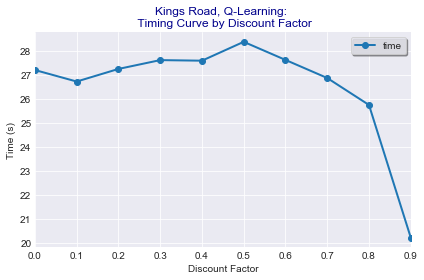

In [319]:
# plot the timing curve by discount factor --------------------

# for VI and PI
if alg_name in ('PI', 'VI'):
    plt.close()
    data.plot('disc', 'time', linewidth=2, marker='o')
    plt.title(prob_title+', '+alg_title+': \n Timing Curve by Discount Factor', loc='center', 
              fontsize=12, fontweight=4, color='darkblue')
    plt.xlabel("Discount Factor")
    plt.ylabel('Time (s)')
    #plt.legend(loc='best', ncol=2)
    plt.xticks(rotation=0)

    plt.legend(frameon=True, loc='best', shadow=True)
    plt.tight_layout()
    plt.savefig(output+alg_name+'/'+prob_name+'_TC_by_disc_factor.png')
    plt.show()

elif alg_name == 'Q':
    # change param to group by to categorical variable
    data['disc'] = data['disc'].astype('category')
    # get mean and median rewards grouping by discount factor
    data_bydisc = data.groupby(['disc'])['time'].mean()

    plt.close()
    data_bydisc.plot(linewidth=2, marker='o')
    plt.title(prob_title+', '+alg_title+': \n Timing Curve by Discount Factor', loc='center', 
              fontsize=12, fontweight=4, color='darkblue')
    plt.xlabel("Discount Factor")
    plt.ylabel('Time (s)')
    #plt.legend(loc='best', ncol=2)
    plt.xticks(rotation=0)

    plt.legend(frameon=True, loc='best', shadow=True)
    plt.tight_layout()
    plt.savefig('../output/report/Q/'+prob_name+'_TC_by_disc_factor.png')
    plt.show()

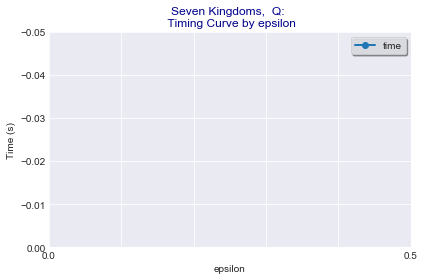

In [294]:
# Q Learning - plot time by different parameters -- Bar Charts

param = ['epsilon', 'alpha'] #, 'q_init', 'epsilon_decay']
param_title = ['Epsilon', 'Learning Rate'] #, 'Initialized Q Value', 'Epsilon Decay']

#for i in range(len(param)):
param = 'epsilon'
# change param to group by to categorical variable
data[param] = data[param].astype('category')
# get mean and median rewards grouping by discount factor
data_byparam = data.groupby(param)['time'].mean()

plt.close()
data_byparam.plot(linewidth=2, marker='o')
plt.title(prob_title+',  Q: \n Timing Curve by '+param, loc='center', 
          fontsize=12, fontweight=4, color='darkblue')
plt.xlabel(param)
plt.ylabel('Time (s)')
plt.ylim(ymax = 0, ymin =-0.05)
plt.gca().invert_yaxis()

plt.legend(frameon=True, loc='best', shadow=True)
plt.tight_layout()
plt.savefig('../output/report/Q/'+prob_name+'_timing_by_'+par+'.png')
plt.show()
i+=1

In [ ]:
envs = [
        {
            # This is not really a rewarding frozen lake env, but the custom class has extra functionality
            'env': environments.get_rewarding_frozen_lake_environment(),
            'name': 'frozen_lake',
            'readable_name': 'Frozen Lake (8x8)',
        },
        
        {
            'env': environments.get_windy_frozen_lake_environment(),
            'name': 'windy_frozen_lake',
            'readable_name': 'Windy Frozen Lake (16x16)',
        }
    ]